In [ ]:
!pip install triton

In [ ]:
!pip install --upgrade triton

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.1/168.1 MB 7.4 MB/s eta 0:00:00
  Attempting uninstall: triton
    Found existing installation: triton 2.3.0
    Uninstalling triton-2.3.0:
      Successfully uninstalled triton-2.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.3.0+cu121 requires nvidia-cublas-cu12==12.1.3.1; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.0+cu121 requires nvidia-cuda-cupti-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.0+cu121 requires nvidia-cuda-nvrtc-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.0+cu121 requires nvidia-cuda-runtime-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3

## UTILS

In [1]:
import os
from IPython.core.debugger import set_trace

# use this for debugging & if incase GPU limit has been exhausted :(
os.environ['TRITON_INTERPRET'] = '1' # needs to be set *before* triton is imported

In [2]:
import os
import triton
import triton.language as tl

def test_pid_conds(conds, pid_0=[0], pid_1=[0], pid_2=[0]):
    '''Test if condition on pids are fulfilled
    E.g.:
        '=0'  checks that pid_0 == 0
        ',>1' checks that pid_1 > 1
        '>1,=0' checks that pid_0 > 1 and pid_1 == 0
    '''
    pids = pid_0[0], pid_1[0], pid_2[0]
    conds = conds.replace(' ','').split(',')
    for i, (cond, pid) in enumerate(zip(conds, pids)):
        if cond=='': continue
        op, threshold = cond[0], int(cond[1:])
        if op not in ['<','>','>=','<=','=', '!=']: raise ValueError(f"Rules may only use these ops: '<','>','>=','<=','=', '!='. Invalid rule: '{conds}'.")
        op = '==' if op == '=' else op
        if not eval(f'{pid} {op} {threshold}'): return False
    return True

assert test_pid_conds('')
assert test_pid_conds('>0', [1], [1])
assert not test_pid_conds('>0', [0], [1])
assert test_pid_conds('=0,=1', [0], [1], [0])

def breakpoint_if(conds, pid_0=[0], pid_1=[0], pid_2=[0]):
    '''Stop kernel, if any condition of pids is fulfilled'''
    from IPython.core.debugger import set_trace

    if test_pid_conds(conds, pid_0, pid_1, pid_2): set_trace()

def print_if(txt, conds, pid_0=[0], pid_1=[0], pid_2=[0]):
    '''Print txt, if any condition of pids is fulfilled'''
    if test_pid_conds(conds, pid_0, pid_1, pid_2): print(txt)

def check_tensors_gpu_ready(*tensors):
    for t in tensors:
        assert t.is_contiguous(), "A tensor is not contiguous"
        if not os.environ.get('TRITON_INTERPRET') == '1': assert t.is_cuda, "A tensor is not on cuda"

def cdiv(a,b): return (a + b - 1) // b
assert cdiv(10,2)==5
assert cdiv(10,3)==4

@triton.jit
def get_1d_offest(size, n_prev_chunks): return n_prev_chunks * size + tl.arange(0, size)

@triton.jit
def get_2d_offset(offs_0, offs_1, stride_0, stride_1=1):  return tl.expand_dims(offs_0, 1)*stride_0 + tl.expand_dims(offs_1, 0)*stride_1

@triton.jit
def get_1d_mask(offs, max): return offs < max

@triton.jit
def get_2d_mask(offs_0, offs_1, max_0, max_1): return (tl.expand_dims(offs_0, 1) < max_0) & (tl.expand_dims(offs_1, 0) < max_1)

## Vector Addition

In [4]:
import torch
import triton
import triton.language as tl

In [7]:
@triton.jit
def add_kernel(
    x_ptr, # internally prepared from torch.Tensor
    y_ptr, # internally prepared from torch.Tensor
    output_ptr, # internally prepared from torch.Tensor
    n_elements, # number of elements present in the Tensor (used for masking to prevent memory bound issues)
    BLOCK_SIZE: tl.constexpr # Size of the BLOCK which will be used by the kernel
  ):

  row_start = tl.program_id(0) # get the kernel info which is going to use a block | 0 -> is the axis (1D, 2D, 3D)

  # Whenever a kernel is launched it takes in a grid | Blocks inside this grid are individual compute units
  # preparing the offset, 0st block -> 0 * 3 + [0,1,2] = [0, 1, 2] (1st block locations)
  # preparing the offset, 1st block -> 1 * 3 + [0,1,2] = [3, 4, 5] (2nd block locations)
  offsets = row_start * BLOCK_SIZE + tl.arange(0, BLOCK_SIZE)
  mask = offsets < n_elements # Masking to avoid going beyond total number of elements present

  x = tl.load(x_ptr + offsets, mask) # loading the vector of values of size BS
  y = tl.load(y_ptr + offsets, mask) # loading the vector of values of size BS

  output = x + y # Add operation on the vectors

  tl.store(output_ptr + offsets, output, mask) # Storing in the required output location


def add(x: torch.Tensor, y: torch.Tensor):
  device = 'cuda' if torch.cuda.is_available() else 'cpu'
  z = torch.empty_like(x, device = device) # initializing the empty output
  # Uncomment the following assert if running on GPU
  # assert x.is_cuda and y.is_cuda and z.is_cuda, f"Inputs should be on CUDA"
  n_elements = x.numel()

  # Creating a function that returns a tuple, information on the grid -> no of blocks present in the grid
  grid = lambda meta: (cdiv(n_elements, meta['BLOCK_SIZE']), ) # The `meta` contains all the kwargs passed when calling the kernel
  add_kernel[grid](x, y, z, n_elements, BLOCK_SIZE = 1024) # call the kernel

  return z

In [8]:
torch.manual_seed(0)
size = 98432
x = torch.rand(size, device='cpu')
y = torch.rand(size, device='cpu')
output_torch = x + y
output_triton = add(x, y)
print(output_torch)
print(output_triton)
print(f'The maximum difference between torch and triton is '
      f'{torch.max(torch.abs(output_torch - output_triton))}')

tensor([0.5151, 1.6826, 0.9153,  ..., 0.9852, 1.2714, 1.8192])
tensor([0.5151, 1.6826, 0.9153,  ..., 0.9852, 1.2714, 1.8192])
The maximum difference between torch and triton is 0.0


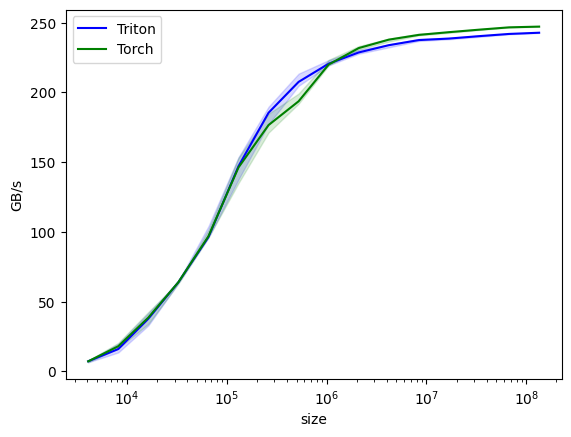

vector-add-performance:
           size      Triton       Torch
0        4096.0    7.314286    7.279621
1        8192.0   16.083770   18.070588
2       16384.0   37.809231   38.641509
3       32768.0   63.999998   63.999998
4       65536.0   96.376474   96.946742
5      131072.0  147.161685  146.285715
6      262144.0  185.479239  176.646904
7      524288.0  207.611406  193.702454
8     1048576.0  220.659939  220.042531
9     2097152.0  228.713669  231.849058
10    4194304.0  233.917907  237.880216
11    8388608.0  237.574814  241.301581
12   16777216.0  238.656247  243.242067
13   33554432.0  240.391097  245.025406
14   67108864.0  241.974426  246.698361
15  134217728.0  242.845956  247.229128


In [ ]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names = ['size'],
        x_vals = [2**i for i in range(12, 28, 1)],
        x_log = True,
        line_arg = 'provider',
        line_vals = ['triton', 'torch'],
        line_names = ['Triton', 'Torch'],
        styles= [('blue', '-'), ('green', '-')],
        ylabel = 'GB/s',
        plot_name= 'vector-add-performance',
        args={},
    )
)

def benchmark(size, provider):
  x = torch.rand(size, device='cuda', dtype=torch.float32)
  y = torch.rand(size, device='cuda', dtype=torch.float32)
  quantiles = [0.5, 0.2, 0.8]
  if provider == 'torch':
    ms, min_ms, max_ms = triton.testing.do_bench(lambda: x+y, quantiles=quantiles)
  if provider == 'triton':
    ms, min_ms, max_ms = triton.testing.do_bench(lambda: add(x, y), quantiles=quantiles)
  gbps = lambda ms: 3 * x.numel() * x.element_size() / ms * 1e-6

  return gbps(ms), gbps(max_ms), gbps(min_ms)

benchmark.run(print_data=True, show_plots=True)

## Subtract Kernel

Recommended to restart the session if using simulation (TRITON_INTERPRET == 1). Buggy!!

In [4]:
import torch
import triton
import triton.language as tl

In [5]:
@triton.jit
def subtract_kernel(
    x_ptr,
    y_ptr,
    output_ptr,
    n_elements,
    BLOCK_SIZE: tl.constexpr
  ):

  row_start = tl.program_id(0)

  offsets = row_start * BLOCK_SIZE + tl.arange(0, BLOCK_SIZE)
  mask = offsets < n_elements

  x = tl.load(x_ptr + offsets, mask)
  y = tl.load(y_ptr + offsets, mask)

  output = x - y

  tl.store(output_ptr + offsets, output, mask)

def subtract(x: torch.Tensor, y: torch.Tensor):
  z = torch.empty_like(x, device = x.device) # initializing the empty output
  # Uncomment the following assert if running on GPU
  # assert x.is_cuda and y.is_cuda and z.is_cuda, f"Inputs should be on CUDA"
  n_elements = x.numel()

  grid = lambda meta: (cdiv(n_elements, meta['BLOCK_SIZE']), )
  subtract_kernel[grid](x, y, z, n_elements, BLOCK_SIZE = 1024)

  return z

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(0)
size = 98432
x = torch.rand(size, device=device)
y = torch.rand(size, device=device)
output_torch = x - y
output_triton = subtract(x, y)
print(output_torch)
print(output_triton)
print(f'The maximum difference between torch and triton is '
      f'{torch.max(torch.abs(output_torch - output_triton))}')

tensor([ 0.4774, -0.1461, -0.7384,  ..., -0.3037, -0.2944,  0.0959])
tensor([ 0.4774, -0.1461, -0.7384,  ..., -0.3037, -0.2944,  0.0959])
The maximum difference between torch and triton is 0.0


## Element-Wise Multiplication

In [3]:
import torch
import triton
import triton.language as tl

In [5]:
@triton.jit
def multiply_kernel(
    x_ptr,
    y_ptr,
    output_ptr,
    n_elements,
    BLOCK_SIZE: tl.constexpr
  ):

  row_start = tl.program_id(0)
  offsets = row_start * BLOCK_SIZE + tl.arange(0, BLOCK_SIZE)
  mask = offsets < n_elements

  x = tl.load(x_ptr + offsets, mask=mask)
  y = tl.load(y_ptr + offsets, mask=mask)

  output = x * y

  # If on CPU then the location is on RAM, if GPU then its the VRAM
  tl.store(output_ptr + offsets, output, mask=mask)

def multiply(x:torch.Tensor, y:torch.Tensor):
  z = torch.empty_like(x, device = x.device)
  # Uncomment the following assert if running on GPU
  # assert x.is_cuda and y.is_cuda and z.is_cuda, f"Inputs should be on CUDA"
  n_elements = x.numel()

  grid = lambda meta: (cdiv(n_elements, meta['BLOCK_SIZE']), )
  multiply_kernel[grid](x, y, z, n_elements, BLOCK_SIZE = 2048)

  return z

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(0)
size = 4096 # 98432
x = torch.rand(size, device=device)
y = torch.rand(size, device=device)
output_torch = x * y
output_triton = multiply(x, y)
print(output_torch)
print(output_triton)
print(f'The maximum difference between torch and triton is '
      f'{torch.max(torch.abs(output_torch - output_triton))}')

tensor([0.4286, 0.3435, 0.0257,  ..., 0.5666, 0.4311, 0.0330])
tensor([0.4286, 0.3435, 0.0257,  ..., 0.5666, 0.4311, 0.0330])
The maximum difference between torch and triton is 0.0


## Element-Wise Division

In [5]:
import torch
import triton
import triton.language as tl

@triton.jit
def division_kernel(
    x_ptr,
    y_ptr,
    output_ptr,
    n_elements,
    BLOCK_SIZE: tl.constexpr
    ):

  row_start = tl.program_id(0)

  offsets = row_start * BLOCK_SIZE + tl.arange(0, BLOCK_SIZE)
  mask = offsets < n_elements

  x = tl.load(x_ptr + offsets, mask=mask)
  y = tl.load(y_ptr + offsets, mask=mask)

  output = x / y

  tl.store(output_ptr + offsets, output, mask=mask)

def division(x: torch.Tensor, y: torch.Tensor):
  z = torch.empty_like(x, device = x.device)
  # Uncomment the following assert if running on GPU
  # assert x.is_cuda and y.is_cuda and z.is_cuda, f"Inputs should be on CUDA"
  n_elements = x.numel()

  grid = lambda meta: (cdiv(n_elements, meta['BLOCK_SIZE']), )

  division_kernel[grid](x, y, z, n_elements, BLOCK_SIZE = 2048)

  return z

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(0)
size = 4096 # 98432
x = torch.rand(size, device=device)
y = torch.rand(size, device=device)
output_torch = x / y
output_triton = division(x, y)
print(output_torch)
print(output_triton)
print(f'The maximum difference between torch and triton is '
      f'{torch.max(torch.abs(output_torch - output_triton))}')

tensor([0.5746, 1.7183, 0.3049,  ..., 0.9082, 0.8896, 0.1226])
tensor([0.5746, 1.7183, 0.3049,  ..., 0.9082, 0.8896, 0.1226])
The maximum difference between torch and triton is 0.0


## Fused Softmax

In [ ]:
import torch
import triton
import triton.language as tl
import triton.runtime.driver

In [ ]:
a = torch.Tensor(2,3)
a

tensor([[-1.1961e-29,  3.0983e-41,  1.5891e-42],
        [ 3.0983e-41, -1.1961e-29,  3.0983e-41]])

In [ ]:
a.max(dim=1)[0]

tensor([3.0983e-41, 3.0983e-41])

In [ ]:
a.max(dim=1)[0][:, None] == a.max(dim=1)[0].view(2,1)

tensor([[True],
        [True]])

In [ ]:
a.max(dim=1)[0].view(2,1)

tensor([[3.0983e-41],
        [3.0983e-41]])

In [ ]:
_ = a - a.max(dim=1)[0][:, None]
_

tensor([[-1.1961e-29,  0.0000e+00, -2.9394e-41],
        [ 0.0000e+00, -1.1961e-29,  0.0000e+00]])

In [ ]:
def naive_softmax(x):
  x_max = x.max(dim=1)
  z = x - x_max[:, None]
  numerator = torch.exp(z)
  denominator = numerator.sum(dim = 1)
  ret = numerator / denominator[:, None]

  return ret

In [ ]:
@triton.jit
def softmax_kernel(
    input_ptr,
    output_ptr,
    input_row_stride,
    output_row_stride,
    n_rows,
    n_cols,
    BLOCK_SIZE: tl.constexpr,
    num_stages: tl.constexpr
  ):

  row_start = tl.program_id(0)
  row_step = tl.num_programs(0)

  for row_idx in tl.range(row_start, n_rows, row_step, num_stages=num_stages):
    row_start_ptr = input_ptr + row_idx * input_row_stride
    col_offsets = tl.arange(0, BLOCK_SIZE)
    input_ptrs = row_start_ptr + col_offsets

    mask = col_offsets < n_cols
    row = tl.load(input_ptrs, mask=mask, other=-float('inf'))

    stable_row = row - tl.max(row, axis = 0)

    numerator = tl.exp(stable_row, axis = 0)
    denominator = tl.sum(numerator, axis = 0)

    softmax_output = numerator / denominator

    output_row_start_pointer = output_ptr + row_idx * output_row_stride

    output_ptrs = output_row_start_pointer + col_offsets

    tl.store(output_ptrs, softmax_output, mask=mask)


In [ ]:
# Initialize triton
triton.init(arch=triton.arch.cuda, device_id=0)

AttributeError: module 'triton' has no attribute 'init'

In [ ]:
device = torch.cuda.current_device()
properties = driver.active.utils.get_device_properties(device)
NUM_SM = properties["multiprocessor_count"]
NUM_REGS = properties["max_num_regs"]
SIZE_SMEM = properties["max_shared_mem"]
WARP_SIZE = properties["warpSize"]
target = triton.runtime.driver.active.get_current_target()
kernels = {}
print(f'SM: {NUM_SM}\nREGS: {NUM_REGS}\nSMEM: {SIZE_SMEM}\nWARP: {WARP_SIZE}\ntarget: {target}')

AttributeError: 'CudaDriver' object has no attribute 'active'

In [ ]:
device = triton.cuda.Device()

# Get device properties
properties = device.properties

AttributeError: module 'triton' has no attribute 'cuda'

NameError: name '__file__' is not defined

In [ ]:
6 | 2

6

In [ ]:
110
011

SyntaxError: leading zeros in decimal integer literals are not permitted; use an 0o prefix for octal integers (<ipython-input-18-af35acd9fc19>, line 2)

In [ ]:
6 >> 1

3

In [ ]:
n = 6 | 6 >> 1

In [ ]:
n = n | n >> 2

In [ ]:
n = n | n >> 4

In [ ]:
n

7

In [ ]:
n = n | n >> 8

In [ ]:
n + 1

8

In [ ]:
6 >> 2

1

In [ ]:
36 >> 2

9